

# SML A2 Q2


(784, 1000)


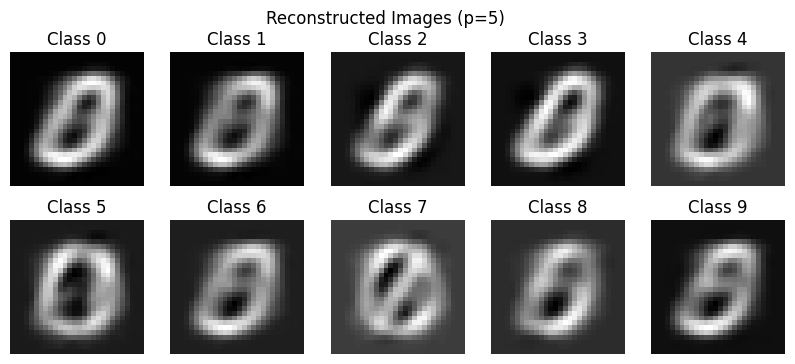

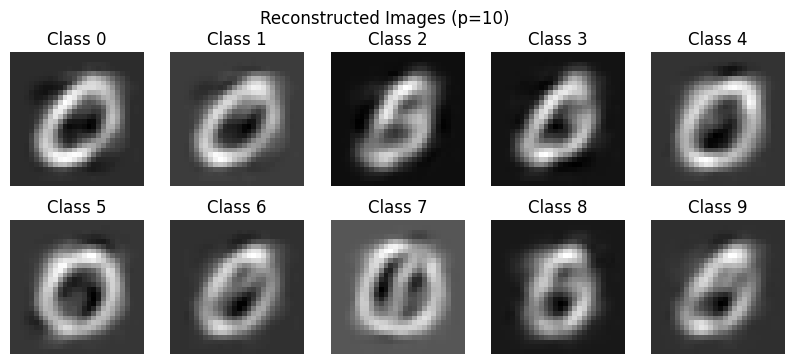

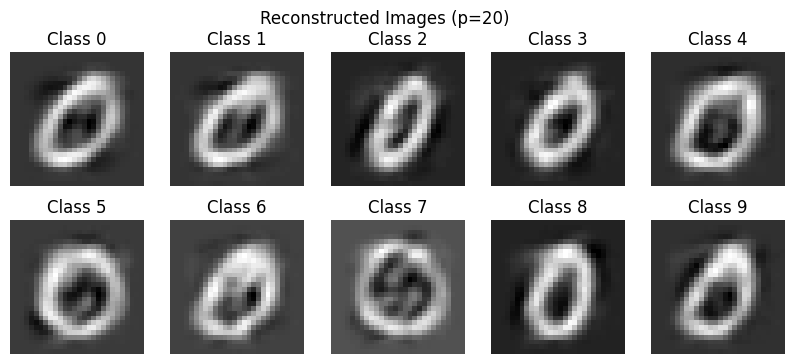

Accuracy on test set after PCA: 0.9084
Per-class accuracy after PCA: [0.9724489795918367, 0.9259911894273127, 0.9486434108527132, 0.8960396039603961, 0.9124236252545825, 0.9091928251121076, 0.9342379958246346, 0.8443579766536965, 0.8439425051334702, 0.8959365708622399]


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.stats import multivariate_normal
from tensorflow.keras.datasets import mnist

# MNIST dataset Load
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 100 samples from each class choosen
num_samples = 100
X_selected = []
y_selected = []

for digit in range(10):
    digit_indices = np.where(y_train == digit)[0][:num_samples]
    X_selected.extend(X_train[digit_indices])
    y_selected.extend([digit] * num_samples)

X_selected = np.array(X_selected)
y_selected = np.array(y_selected)

# Flattening images to create X
X = X_selected.reshape(-1, 28*28).T

# Removed mean from X
X_mean = np.mean(X, axis=1, keepdims=True)
X_centered = X - X_mean
print(X_centered.shape)
def pca(X, num_components, reg_param=1e-5):
    # covariance matrix
    # S = np.dot(X, X.T) / (X.shape[1] - 1)
    S = np.dot(X_centered, X_centered.T) / 999
    S += reg_param * np.eye(X.shape[0])

    # eigenvectors and eigenvalues
    eigenvalues, eigenvectors = eigh(S)

    # Sorting eigenvectors and eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # top num_components eigenvectors
    U = eigenvectors[:, :num_components]

    # Projecting the data onto the new subspace
    Y = np.dot(U.T, X)

    # X_reconstructed = np.dot(U, Y) + X_mean
    X_reconstructed = np.dot(U, Y)


    # Mean Squared Error
    mse = np.mean((X - X_reconstructed)**2)
    return U, Y, mse

# Visualization of reconstructed images for different numbers of principal components
num_components_to_visualize = [5, 10, 20]

for num_components in num_components_to_visualize:
    # PCA
    U, Y, mse = pca(X_centered, num_components,reg_param=1e-5)

    # Reconstruct X using a subset of principal components
    X_reconstructed_subset = np.dot(U, Y) + X_mean

    # Plot reconstructed images
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):

        ax = axs[i // 5, i % 5]
        ax.imshow(X_reconstructed_subset[:, i].reshape(28, 28), cmap='gray')

        ax.axis('off')
        ax.set_title(f"Class {i}")
    plt.suptitle(f"Reconstructed Images (p={num_components})")
    plt.show()

# PCA on test set
X_test_flattened = X_test.reshape(-1, 28*28).T
X_test_centered = X_test_flattened - X_mean

# PCA for the test set using the eigenvectors obtained from the training set
Y_test = np.dot(U.T, X_test_centered)

def qda_discriminant(x, mean, cov, prior, reg_param=1e-5):
    p = x.shape[0]  # Number of features
    # det_cov = np.linalg.det(cov)
    det_cov = np.linalg.det(cov + reg_param * np.eye(p))
    inv_cov = np.linalg.inv(cov + reg_param * np.eye(p))  # Regularization

    exponent_term = -0.5 * np.dot(np.dot((x - mean).T, inv_cov), (x - mean))
    log_det_cov_term = -0.5 * np.log(det_cov)
    log_prior_term = np.log(prior)

    discriminant_value = log_det_cov_term + exponent_term + log_prior_term

    return discriminant_value

def qda_predict(X, means, covs, priors, reg_param=1e-5):
    n_classes = len(means)
    n_samples = X.shape[1]
    probabilities = np.zeros((n_samples, n_classes))
    for i in range(n_classes):
        for j in range(n_samples):
            probabilities[j, i] = qda_discriminant(X[:, j], means[i], covs[i], priors[i], reg_param)
    return np.argmax(probabilities, axis=1)

means_pca = []
covs_pca = []

for digit in range(10):
    digit_indices = np.where(y_selected == digit)[0]
    X_digit = Y[:, digit_indices]

    mean_digit_pca = np.mean(X_digit, axis=1)
    cov_digit_pca = np.cov(X_digit)

    means_pca.append(mean_digit_pca)
    covs_pca.append(cov_digit_pca)

# PCA to the test set
X_test_flattened_pca = X_test_flattened - X_mean  # Remove mean
Y_test_pca = np.dot(U.T, X_test_flattened_pca)

class_counts = np.bincount(y_selected)
total_samples = len(y_selected)
priors = class_counts / total_samples
predictions_pca = qda_predict(Y_test_pca, means_pca, covs_pca, priors)

accuracy_pca = np.mean(predictions_pca == y_test)
print("Accuracy on test set after PCA:", accuracy_pca)

# Per-class accuracy after PCA
class_accuracy_pca = []
for digit in range(10):
    digit_indices = np.where(y_test == digit)[0]
    class_predictions_pca = predictions_pca[digit_indices]
    class_accuracy_pca.append(np.mean(class_predictions_pca == digit))

print("Per-class accuracy after PCA:", class_accuracy_pca)